# Машинное обучение, ФКН ВШЭ

# Практическое задание 12. Несбалансированные задачи

Дата выдачи: 01.05.2022

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [2]:
df = pd.read_csv('data/creditcard.csv')

In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [4]:
df[df.Class == 1].shape[0] / df.shape[0]

0.001727485630620034

*Доля объектов положительного класса составляет менее 1%.*

Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [5]:
df.Time.max() / 60 / 60 / 24

1.9999074074074075

*Данные покрывают два дня.*

**Демо-вариант: колхоз. Адекватно: через `datetime`.**

In [6]:
df['Day'] = (df.Time >= 24 * 3600).astype(int)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Day
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,1
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,1
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,1


In [7]:
df['Hour'] = np.rint(df.Time / 3600) % 24
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Day,Hour
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1,0.0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,1,0.0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,1,0.0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,1,0.0


Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

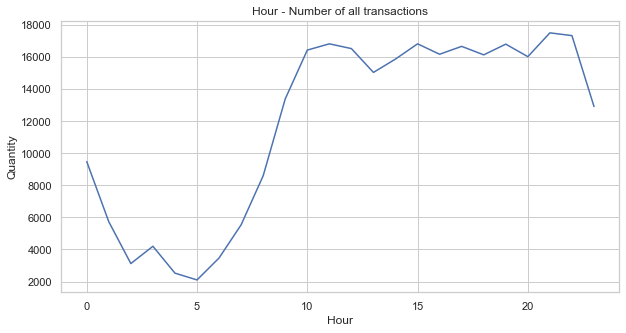

In [8]:
dfg = df.groupby(['Hour'], as_index=False).size()
_, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='Hour', y='size', data=dfg, ax=ax)
ax.set_ylabel('Quantity')
plt.title('Hour - Number of all transactions')
plt.show()

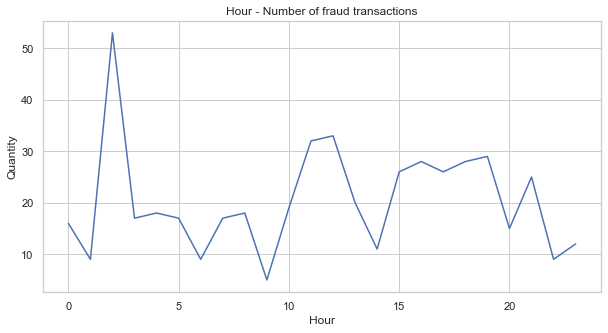

In [9]:
dfg = df[df.Class == 1].groupby(['Hour'], as_index=False).size()
_, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='Hour', y='size', data=dfg, ax=ax)
ax.set_ylabel('Quantity')
plt.title('Hour - Number of fraud transactions')
plt.show()

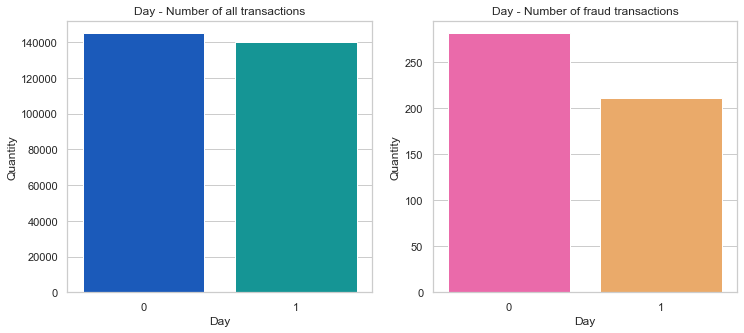

In [10]:
_, axes = plt.subplots(ncols=2, figsize=(12, 5))

dfg = df.groupby(['Day'], as_index=False).size()
sns.barplot(x='Day', y='size', data=dfg, ax=axes[0], palette='winter')
axes[0].set_ylabel('Quantity')
axes[0].set_title('Day - Number of all transactions')


dfg = df[df.Class == 1].groupby(['Day'], as_index=False).size()
sns.barplot(x='Day', y='size', data=dfg, ax=axes[1], palette='spring')
axes[1].set_ylabel('Quantity')
axes[1].set_title('Day - Number of fraud transactions')

plt.show()

**Выводы:** естественно, чем больше транзакций в день, тем больше среди них фрода. График *Hour - Number of all transactions* в целом соответствует, так сказать, ритму жизни: транзакций меньше под утро и больше к рабочим часам. Примечательно, что с 10 до 22 часов нет сильных колебаний по количеству. Что интересного с фродом, так это то, что наибольшее число таких транзакций проиходит в тот момент, когда общее число транзакций минимальное. После 5 часов сложно выявить какую-нибудь закономерность.

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

In [11]:
numeric = ['V' + str(i) for i in range(1, 29)]

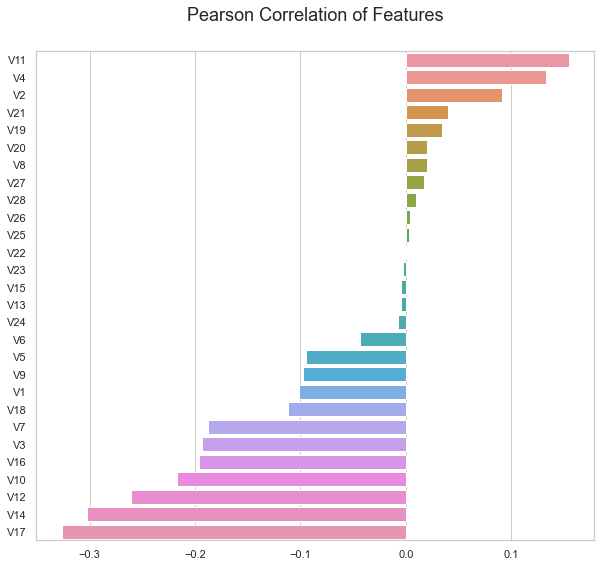

In [12]:
plt.figure(figsize=(10, 9))
correlations = df[numeric].corrwith(df.Class).sort_values(ascending=False)
corrs = correlations.index.tolist()
sns.barplot(y=corrs, x=correlations)
plt.title('Pearson Correlation of Features', y=1.05, size=18)
plt.show()

In [13]:
n, m = 3, 5
new_numeric = corrs[:n] + corrs[-m:]
new_numeric

['V11', 'V4', 'V2', 'V16', 'V10', 'V12', 'V14', 'V17']

**Распределения:**

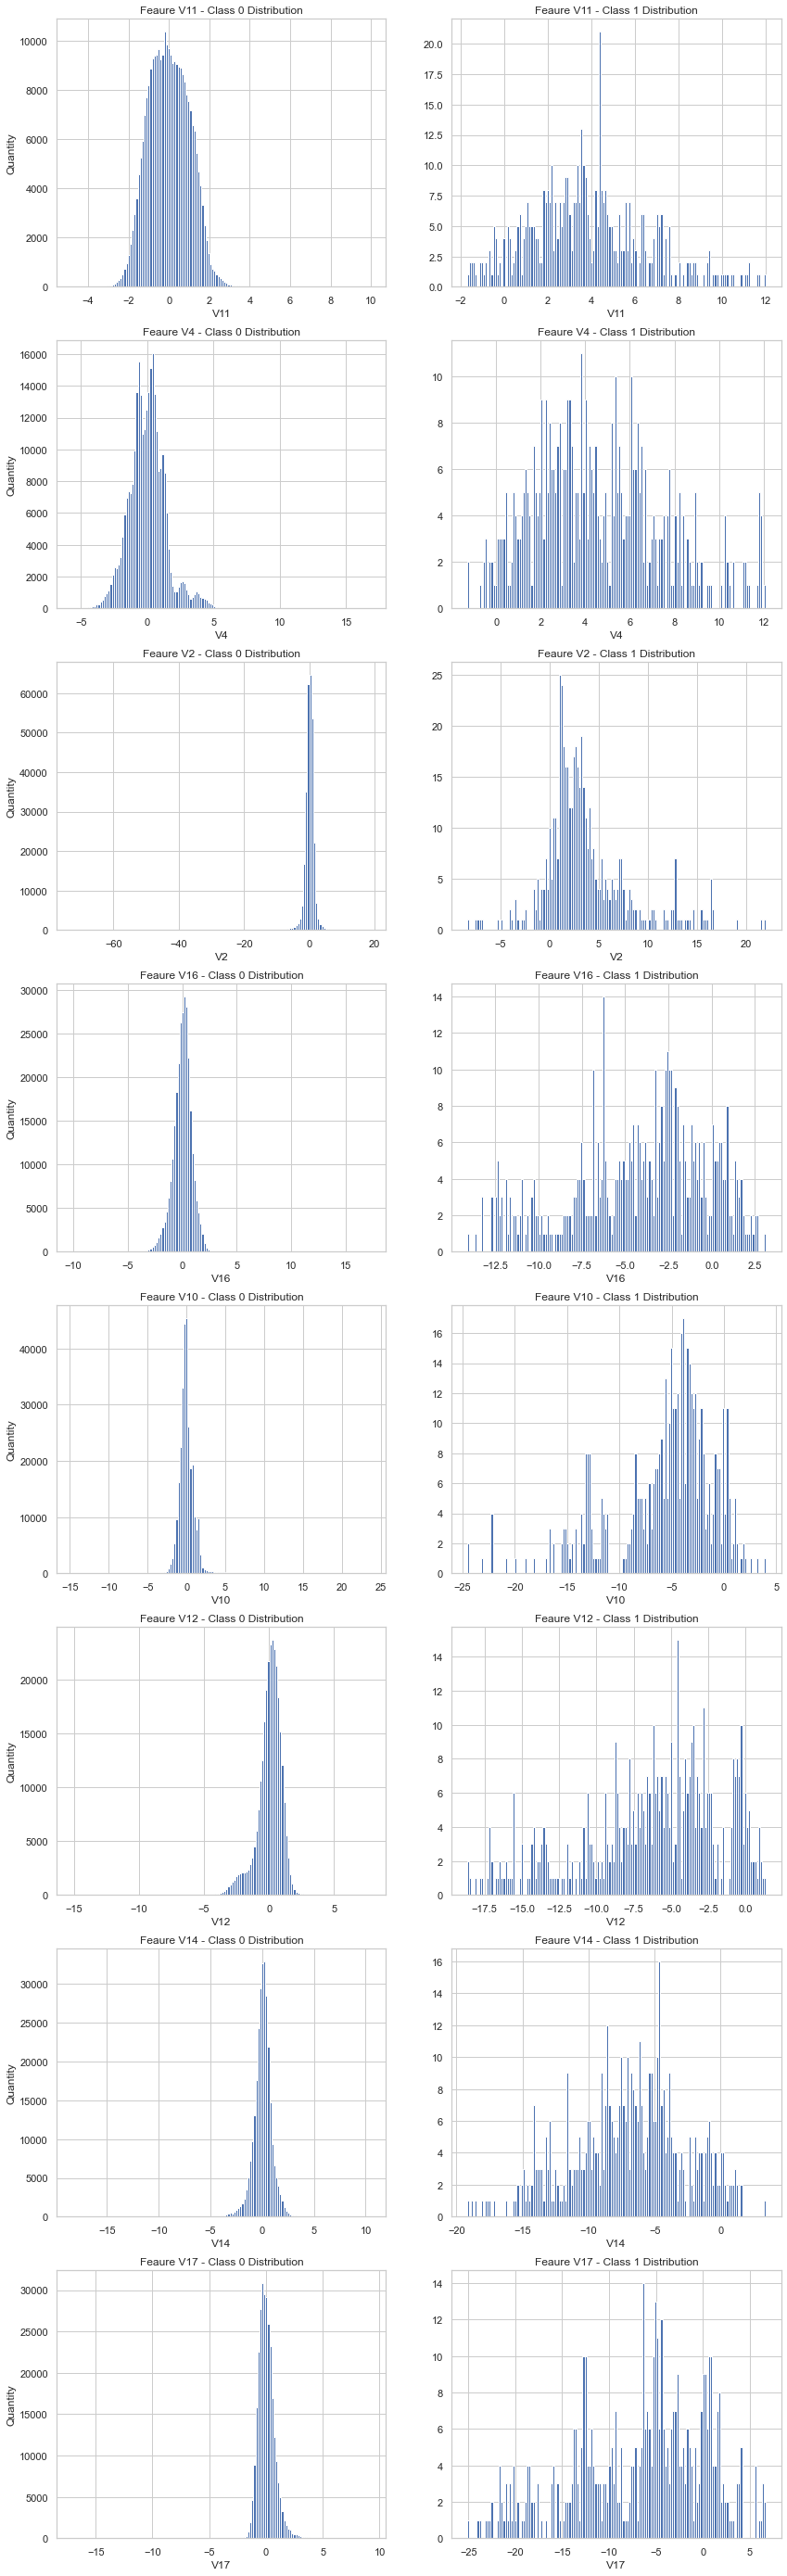

In [14]:
fig, axes = plt.subplots(nrows=(m + n), ncols=2, figsize=(14, 50))

for i, feat in enumerate(new_numeric):
    axes[i][0].hist(x=df[df.Class == 0][feat].values, bins=150)
    axes[i][1].hist(x=df[df.Class == 1][feat].values, bins=150)
    axes[i][0].set(xlabel=feat, ylabel='Quantity', title='Feaure ' + feat + ' - Class 0 Distribution')
    axes[i][1].set(xlabel=feat, title='Feaure ' + feat + ' - Class 1 Distribution')
plt.show()

Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [15]:
slice_ = int(df.shape[0] * 0.8)
df_tmp = df.sort_values('Time').iloc[slice_:]
df_train = df.sort_values('Time').iloc[:slice_]
df_tmp.shape[0] / df.shape[0]

0.20000210668979343

In [16]:
slice_ = int(df_tmp.shape[0] / 2)
df_valid = df_tmp.iloc[slice_:]
df_test = df_tmp.iloc[:slice_]
df_valid.shape[0] / df_tmp.shape[0], df_test.shape[0] / df_tmp.shape[0]

(0.5, 0.5)

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

In [17]:
from sklearn.metrics import precision_recall_curve, auc

def auc_pr(y, y_proba):
    pr, rec, _ = precision_recall_curve(y, y_proba)
    return auc(rec, pr)

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [18]:
from sklearn.metrics import accuracy_score

def ck_coeff(y, y_proba, treshold=0.5, mode='proba'):
    n = len(y)
    if mode == 'proba':
        y_preds = (y_proba >= treshold).astype(int)
    elif mode == 'preds':
        y_preds = y_proba.copy()
    else:
        raise ValueError('Unknown mode')
        
    p0 = accuracy_score(y, y_preds)
    tmp1 = np.count_nonzero(y) * np.count_nonzero(y_preds)
    tmp2 = (n - np.count_nonzero(y)) * (n - np.count_nonzero(y_preds))
    pe = (tmp1 + tmp2) / n ** 2
    return (p0 - pe) / (1 - pe)

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

In [19]:
from sklearn.metrics import confusion_matrix

def matthews_corr_coeff(y, y_proba, treshold=0.5, mode='proba'):
    if mode == 'proba':
        y_preds = (y_proba >= treshold).astype(int)
    elif mode == 'preds':
        y_preds = y_proba.copy()
    else:
        raise ValueError('Unknown mode')
        
    TN, FP, FN, TP = confusion_matrix(y, y_preds).ravel()
    num = TP * TN - FP * FN
    denom = (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)
    if num == 0:
        return 0.0
    return num / np.sqrt(denom)

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [20]:
y = df.Class.to_numpy().copy()
n = len(y)
y_pred = np.zeros(n)

ck_coeff(y, y_pred, mode='preds'), matthews_corr_coeff(y, y_pred, mode='preds')

(0.0, 0.0)

Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [21]:
# Стоит ли выкинуть время?
X_train = df_train.drop(columns='Class').to_numpy()
y_train = df_train.Class.to_numpy()

X_test = df_test.drop(columns='Class').to_numpy()
y_test = df_test.Class.to_numpy()

X_valid = df_valid.drop(columns='Class').to_numpy()
y_valid = df_valid.Class.to_numpy()

def print_results(prob_train=None, prob_valid=None, prob_test=None, tr_kappa=0.5, tr_matthews=0.5, mode='proba'):
    if prob_train is not None:
        print('Train:')
        print('Cohen\'s Kappa: {:.4f}\
            Matthew\'s Corr: {:.4f}'.format(ck_coeff(y_train, prob_train, tr_kappa, mode),
                                            matthews_corr_coeff(y_train, prob_train, tr_matthews, mode)))
        print()
    if prob_valid is not None:
        print('Valid:')
        print('Cohen\'s Kappa: {:.4f}\
            Matthew\'s Corr: {:.4f}'.format(ck_coeff(y_valid, prob_valid, tr_kappa, mode),
                                            matthews_corr_coeff(y_valid, prob_valid, tr_matthews, mode)))
        print()
        
    if prob_test is not None:
        print('Test:')
        print('Cohen\'s Kappa: {:.4f}\
            Matthew\'s Corr: {:.4f}'.format(ck_coeff(y_test, prob_test, tr_kappa, mode),
                                            matthews_corr_coeff(y_test, prob_test, tr_matthews, mode)))
        print()

In [22]:
from catboost import CatBoostClassifier

kwargs = {
    'learning_rate':0.07,
    'max_depth':5,
    'n_estimators':50,
    'random_state':10,
    'reg_lambda':15.0,
}

catboost = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_train, y_train, verbose=False)

In [23]:
y_proba_valid = catboost.predict_proba(X_valid)[:, 1]
y_proba_train = catboost.predict_proba(X_train)[:, 1]
y_proba_test = catboost.predict_proba(X_test)[:, 1]
    
print_results(y_proba_train, y_proba_valid, y_proba_test)

Train:
Cohen's Kappa: 0.8717            Matthew's Corr: 0.8744

Valid:
Cohen's Kappa: 0.7367            Matthew's Corr: 0.7460

Test:
Cohen's Kappa: 0.8087            Matthew's Corr: 0.8239



Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [24]:
kwargs = {
    'learning_rate':0.07,
    'max_depth':5,
    'n_estimators':50,
    'random_state':10,
    'reg_lambda':15.0,
    'class_weights':[0.8, 5],
#     'scale_pos_weight':7,
}

catboost = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_train, y_train, verbose=False)

y_proba_valid = catboost.predict_proba(X_valid)[:, 1]
y_proba_train = catboost.predict_proba(X_train)[:, 1]
y_proba_test = catboost.predict_proba(X_test)[:, 1]
    
print_results(y_proba_train, y_proba_valid, y_proba_test)

Train:
Cohen's Kappa: 0.8466            Matthew's Corr: 0.8466

Valid:
Cohen's Kappa: 0.7109            Matthew's Corr: 0.7111

Test:
Cohen's Kappa: 0.8331            Matthew's Corr: 0.8376



Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

In [25]:
import optuna

def objective(trial):
    param = {
        'scale_pos_weight':trial.suggest_float('scale_pos_weight', 0.2, 20, step=0.2),
        'learning_rate':0.07,
        'max_depth':5,
        'n_estimators':50,
        'random_state':10,
        'reg_lambda':15.0,
    }


    catboost = CatBoostClassifier(**param, task_type='GPU', devices='0:1')
    catboost.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], 
                 verbose=False, early_stopping_rounds=100)

    y_proba_valid = catboost.predict_proba(X_valid)[:, 1]
    return auc_pr(y_valid, y_proba_valid)

In [26]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

[I 2022-05-12 08:05:31,421] A new study created in memory with name: no-name-b2f208fb-a13a-4113-bcf8-0ece5c53fe6e
[I 2022-05-12 08:05:33,488] Trial 0 finished with value: 0.6594470539491095 and parameters: {'scale_pos_weight': 5.800000000000001}. Best is trial 0 with value: 0.6594470539491095.
[I 2022-05-12 08:05:35,135] Trial 1 finished with value: 0.5644808870862319 and parameters: {'scale_pos_weight': 2.4000000000000004}. Best is trial 0 with value: 0.6594470539491095.
[I 2022-05-12 08:05:37,041] Trial 2 finished with value: 0.6485198122978778 and parameters: {'scale_pos_weight': 19.2}. Best is trial 0 with value: 0.6594470539491095.
[I 2022-05-12 08:05:38,997] Trial 3 finished with value: 0.6545000076071188 and parameters: {'scale_pos_weight': 17.2}. Best is trial 0 with value: 0.6594470539491095.
[I 2022-05-12 08:05:40,623] Trial 4 finished with value: 0.6667171105439811 and parameters: {'scale_pos_weight': 10.2}. Best is trial 4 with value: 0.6667171105439811.
[I 2022-05-12 08:05

[I 2022-05-12 08:06:49,389] Trial 43 finished with value: 0.6276671927202453 and parameters: {'scale_pos_weight': 5.2}. Best is trial 15 with value: 0.6799535664288205.
[I 2022-05-12 08:06:51,159] Trial 44 finished with value: 0.6681739754838489 and parameters: {'scale_pos_weight': 10.0}. Best is trial 15 with value: 0.6799535664288205.
[I 2022-05-12 08:06:53,260] Trial 45 finished with value: 0.6671782339032313 and parameters: {'scale_pos_weight': 9.4}. Best is trial 15 with value: 0.6799535664288205.
[I 2022-05-12 08:06:55,339] Trial 46 finished with value: 0.6276671927202453 and parameters: {'scale_pos_weight': 5.2}. Best is trial 15 with value: 0.6799535664288205.
[I 2022-05-12 08:06:58,445] Trial 47 finished with value: 0.6772769235471549 and parameters: {'scale_pos_weight': 3.2}. Best is trial 15 with value: 0.6799535664288205.
[I 2022-05-12 08:07:01,429] Trial 48 finished with value: 0.6269561514547263 and parameters: {'scale_pos_weight': 3.0000000000000004}. Best is trial 15 wi

[I 2022-05-12 08:08:32,492] Trial 87 finished with value: 0.6469902177402951 and parameters: {'scale_pos_weight': 6.800000000000001}. Best is trial 15 with value: 0.6799535664288205.
[I 2022-05-12 08:08:34,340] Trial 88 finished with value: 0.6601546352074849 and parameters: {'scale_pos_weight': 4.6000000000000005}. Best is trial 15 with value: 0.6799535664288205.
[I 2022-05-12 08:08:37,052] Trial 89 finished with value: 0.6486413276381472 and parameters: {'scale_pos_weight': 6.2}. Best is trial 15 with value: 0.6799535664288205.
[I 2022-05-12 08:08:40,195] Trial 90 finished with value: 0.6772769235471549 and parameters: {'scale_pos_weight': 3.2}. Best is trial 15 with value: 0.6799535664288205.
[I 2022-05-12 08:08:42,997] Trial 91 finished with value: 0.6183239424822935 and parameters: {'scale_pos_weight': 0.8}. Best is trial 15 with value: 0.6799535664288205.
[I 2022-05-12 08:08:45,497] Trial 92 finished with value: 0.6772769235471549 and parameters: {'scale_pos_weight': 3.2}. Best i

C:\Users\Oleg\AppData\Local\Temp/ipykernel_9260/1974320164.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_plt.plot_optimization_history(study);


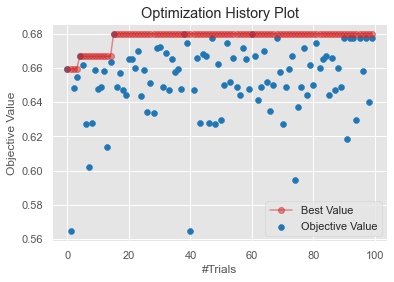

In [27]:
import optuna.visualization.matplotlib as optuna_plt
optuna_plt.plot_optimization_history(study);

In [28]:
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
print("    {}: {}".format('scale_pos_weight', trial.params['scale_pos_weight']))

Best trial:
  Value: 0.6799535664288205
  Params: 
    scale_pos_weight: 9.6


In [29]:
kwargs = {
        'scale_pos_weight':trial.params['scale_pos_weight'],
        'learning_rate':0.07,
        'max_depth':5,
        'n_estimators':50,
        'random_state':10,
        'reg_lambda':15.0,
    }

catboost = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_train, y_train, verbose=False)
y_proba_valid = catboost.predict_proba(X_valid)[:, 1]
y_proba_train = catboost.predict_proba(X_train)[:, 1]
y_proba_test = catboost.predict_proba(X_test)[:, 1]
    
print_results(y_proba_train, y_proba_valid, y_proba_test)

Train:
Cohen's Kappa: 0.8411            Matthew's Corr: 0.8412

Valid:
Cohen's Kappa: 0.7271            Matthew's Corr: 0.7271

Test:
Cohen's Kappa: 0.8244            Matthew's Corr: 0.8280



In [30]:
tresholds = [0.05 * _ for _ in range(1, 20)]
metrics_dict = {'kappa':[], 'matthew':[]}

for tr in tresholds:
    metrics_dict['kappa'].append(ck_coeff(y_valid, y_proba_valid, treshold=tr))
    metrics_dict['matthew'].append(matthews_corr_coeff(y_valid, y_proba_valid, treshold=tr))
    
kappa = tresholds[np.argmax(metrics_dict['kappa'])]
matthew = tresholds[np.argmax(metrics_dict['matthew'])]

print_results(prob_test = y_proba_test, tr_kappa=kappa, tr_matthews=matthew)

Test:
Cohen's Kappa: 0.8244            Matthew's Corr: 0.8280



In [31]:
kappa, matthew

(0.5, 0.5)

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [32]:
kwargs = {
        'class_weights':[1, 0.1],
        'learning_rate':0.07,
        'max_depth':5,
        'n_estimators':50,
        'random_state':10,
        'reg_lambda':15.0,
    }

catboost = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_train, y_train, verbose=False)
y_proba_test = catboost.predict_proba(X_test)[:, 1]

print_results(prob_test = y_proba_test, tr_kappa=kappa, tr_matthews=matthew)

Test:
Cohen's Kappa: 0.7526            Matthew's Corr: 0.7767



In [33]:
kwargs = {
        'class_weights':[1, 100],
        'learning_rate':0.07,
        'max_depth':5,
        'n_estimators':50,
        'random_state':10,
        'reg_lambda':15.0,
    }

catboost = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_train, y_train, verbose=False)
y_proba_test = catboost.predict_proba(X_test)[:, 1]

print_results(prob_test = y_proba_test, tr_kappa=kappa, tr_matthews=matthew)

Test:
Cohen's Kappa: 0.6868            Matthew's Corr: 0.6972



**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [34]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_resampled, y_resampled = SMOTE(random_state=10).fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_resampled).items()))

[(0, 227428), (1, 417)]
[(0, 227428), (1, 227428)]


Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [35]:
kwargs = {
        'scale_pos_weight':trial.params['scale_pos_weight'],
        'learning_rate':0.07,
        'max_depth':5,
        'n_estimators':50,
        'random_state':10,
        'reg_lambda':15.0,
    }

catboost = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_resampled, y_resampled, verbose=False)
y_proba_test = catboost.predict_proba(X_test)[:, 1]

print_results(prob_test = y_proba_test, tr_kappa=kappa, tr_matthews=matthew)

Test:
Cohen's Kappa: 0.0728            Matthew's Corr: 0.1869



Полное выравнивание -- плохо, что и понятно, ведь мы насэмплировали огромное количество объектов.

In [36]:
X_resampled, y_resampled = SMOTE(sampling_strategy=0.1, random_state=10).fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))
print()

catboost = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_resampled, y_resampled, verbose=False)

# y_proba_valid = catboost.predict_proba(X_valid)
# y_proba_train = catboost.predict_proba(X_train)
    
# print_results(y_proba_train, y_proba_valid)

y_proba_test = catboost.predict_proba(X_test)[:, 1]

print_results(prob_test = y_proba_test, tr_kappa=kappa, tr_matthews=matthew)

[(0, 227428), (1, 22742)]

Test:
Cohen's Kappa: 0.3362            Matthew's Corr: 0.4252



Частичное показало себя намного лучше, но при этом качество все равно хуже, чем если бы мы обучали без ресэмплинга.

**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

`BorderlineSMOTE`:
Используя обычный SMOTE на наборе данных, где несколько объектов миноритарного класса (например, выбросы) "вкраплены" в скопление объектов мажоритарного класса, может возникнуть проблема. Она заключается в том, что новые синтетические объекты миноритарного класса смешаются с объектами мажоритарного класса, из-за чего возникнет путанница в распределениях классов. Для решения этой проблемы был придуман BorderlineSMOTE.

Как работает метод: для каждого объекта миноритарного класса считается $m$ его ближайших соседей, из которых $m'$ -- принадлежат мажоритарному классу. Далее рассматриваются случаи:
* 1. Если все соседи объекта -- мажоритарные, т.е. $m = m'$, то этот объект объявляется шумовым и исключается.
* 2. Если же не меньше половины соседей объекта -- мажоритарные ($\frac{m}{2} \le m' < m$), то такая точка является *граничной* или *опасной*, так как на ней можно легко ошибиться.
* 3. Остальные точки, т. что $0 \le m' < \frac{m}{2}$ тоже исключаются.

Задача алгоритма -- насэмплировать больше граничных точек `SMOTE`-аналогичным образом. Таким образом, происходит некоторое отделение классов друг от друга путем генерации объектов по границе. Но здесь есть проблема: алгоритм придает большее значение экстремальным (граничным) объектам и игнорирует объекты третьей категории, что может также подпортить распределение объектов (например, если кластеры объектов разных классов расположены далеко друг от друга, а граничные -- где-то посередине). Вероятно, после применения этого метода можно применить и обычный SMOTE, но решить данную проблему призван алгоритм `ADASYN`.

`ADASYN`:

Суть метода в адаптивной генерации объектов: там, где их мало -- будет сгенерировано больше. Для этого для каждой точки миноритарного класса алгорит смотрит на ее $K$ ближайших соседей и считает соотношение $\frac{\text{#объектов мажоритарного класса среди K}}{K}$, нормализуя его. Интерпретируя полученное значение как плотность конкретного миноритарного объекта, алгоритм использует его для определения числа сэмплов, которое будет сгенерировано (SMOTE-методом) вокруг этого объекта. Чем больше соотношение (чем больше мажоритарных точек окружают объект), тем больше вокруг этого объекта будет создано новых минорных объектов.

`SVM-SMOTE`:

Выбор с помощью SVM объекта, через который будет проходить генерация новых сэмплов.

Основной мотивацией выбора SVM послужила особенность алгоритма, благодаря которой он не чувствителен к несбалансированной выборке (*N. Japkowicz and S. Stephen. The Class Imbalance Problem: A Systematic Study. Intelligent Data Analysis, Vol. 6(5) pp. 429-449, 2002.*), однако из-за разреженности объектов миноритарного класса разделяющая гиперплоскость смещается в сторону этих объектов, так как вероятность увидеть их вблизи границы -- мала. Именно поэтому предлагается сгенерировать новые объекты вблизи гиперплоскости в виду того, что точки в этой области очень важны для оценки оптимальной границы принятия решения. В максимально упрощенном виде, алгоритм таков:

* Построение SVM-модели.
* Создание новых объектов вдоль линий, соединяющих каждый опорный вектор миноритарного класса с его ближайшими соседями.

-  "Отличительной особенностью предлагаемого метода по сравнению с SMOTE является то, что новые экземпляры будут создаваться в порядке от первого до k-го ближайшего соседа вместо случайного выбора ближайшего соседа".

Таким образом, это позволяет приблизить гиперплоскость к идеальной разделяющей границе, что несомненно увеличивает качество.

`K-Means-SMOTE`:

Алгоритм чем-то схож с ADASYM на мой взгляд: что там, что здесь объекты сэмплируются вокруг некоторой области, однако сами области различаются (в ADASYM это ближайшие соседи вокруг низкоплотностных миноритарных объектов; в K-Means-SMOTE -- это кластеры). Алгоритм достаточно прост:

* Кластеризация с помощью KMeans (на всей выборке).
* Фильтрация: выбор подходящих кластеров с высокой долей объектов миноритарного класса на основе заданного в качестве гиперпараметра порога.
* Генерация миноритарных объектов с помощью SMOTE в каждом выбранном кластере. Аналогично ADASYM, где объектов меньше -- там их будет насэмплированно больше, и наоборот.

Таким образом, достигается сбалансированность в распределении миноритарных объектов (а не только сбалансированность выборки в целом), что и определяется как одна из целей алгоритма (на мой взгляд, это очень хорошо).

Теперь попробуйте сравнить качество всех методов на наших данных.

Для чистоты эксперимента я буду использовать одинаковый набор *общих* гиперпараметров для всех алгоритмов. Остальные оставляю по умолчанию.

In [37]:
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, ADASYN

kwargs_general = {
    'random_state':10,
    'sampling_strategy':0.003,
    'k_neighbors':3,
    'n_jobs':-1
}

X_res_bl, y_res_bl = BorderlineSMOTE(**kwargs_general).fit_resample(X_train, y_train)
X_res_svm, y_res_svm = SVMSMOTE(**kwargs_general).fit_resample(X_train, y_train)
# X_res_km, y_res_km = KMeansSMOTE(**kwargs_general, kmeans_estimator=7000).fit_resample(X_train, y_train)
del kwargs_general['k_neighbors']
X_res_ada, y_res_ada = ADASYN(**kwargs_general, n_neighbors=3).fit_resample(X_train, y_train)

cb_bl = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_res_bl, y_res_bl, verbose=False)
cb_svm = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_res_svm, y_res_svm, verbose=False)
# cb_km = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_res_km, y_res_km, verbose=False)
cb_ada = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_res_ada, y_res_ada, verbose=False)

In [38]:
df_results = pd.DataFrame(index=['AUC-PR', 'Kappa', 'MCC'])
for (cb, name) in [(cb_bl, 'BorderlineSMOTE'), (cb_svm, 'SVMSMOTE'), (cb_ada, 'ADASYN')]:
    metric_values = []
    for metric in [auc_pr, ck_coeff, matthews_corr_coeff]:
        y_test_proba = cb.predict_proba(X_test)[:, 1]
        metric_values.append(metric(y_test, y_test_proba))
    df_results[name] = metric_values

df_results

,BorderlineSMOTE,SVMSMOTE,ADASYN
AUC-PR,0.841725,0.845955,0.852335
Kappa,0.783927,0.845099,0.818713
MCC,0.784533,0.848773,0.818751


К сожалению, `KMeansSMOTE` у меня не запустился ни на локалке, ни в коллабе: то ошибка с утечкой памяти, то math domain error, то еще что-то. На мой взгляд лучше всех себя показал `BorderlineSMOTE` при стандартном пороге в 0.5. `ADASYN` превосходит его только по AUC-PR, но если подобрать оптимальное значение порога, то может быть лучше и по другим метрикам.

In [39]:
y_valid_proba = cb_ada.predict_proba(X_valid)[:, 1]
y_test_proba = cb_ada.predict_proba(X_test)[:, 1]

tresholds = [0.05 * _ for _ in range(1, 20)]
metrics_dict = {'kappa':[], 'matthew':[]}

for tr in tresholds:
    metrics_dict['kappa'].append(ck_coeff(y_valid, y_valid_proba, treshold=tr))
    metrics_dict['matthew'].append(matthews_corr_coeff(y_valid, y_valid_proba, treshold=tr))
    
kappa = tresholds[np.argmax(metrics_dict['kappa'])]
matthew = tresholds[np.argmax(metrics_dict['matthew'])]

print_results(prob_test = y_test_proba, tr_kappa=kappa, tr_matthews=matthew)
kappa, matthew

Test:
Cohen's Kappa: 0.8295            Matthew's Corr: 0.8364



(0.9, 0.9)

Увы, но нет. `SVMSMOTE` показал себя лучше всех.

**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [40]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=0.002, random_state=10)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))
print()

catboost = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_resampled, y_resampled, verbose=False)

y_proba_test = catboost.predict_proba(X_test)[:, 1]

print_results(prob_test = y_proba_test, tr_kappa=kappa, tr_matthews=matthew)

# Test:
# Cohen's Kappa: 0.8539            Matthew's Corr: 0.8586

[(0, 208500), (1, 417)]

Test:
Cohen's Kappa: 0.8087            Matthew's Corr: 0.8239



metric:   0%|          | 0/3 [00:00<?, ?it/s]

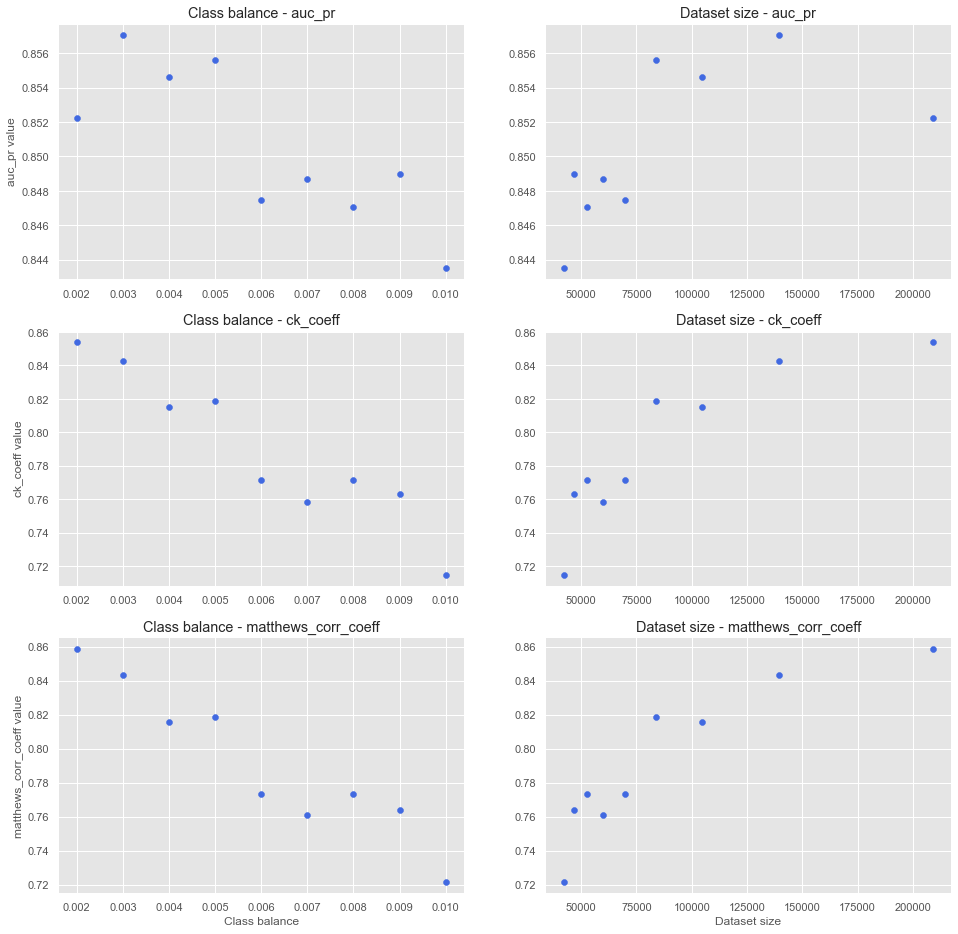

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))

parts = [0.001 * i for i in range(2, 11)]


for i, metric in enumerate(tqdm([auc_pr, ck_coeff, matthews_corr_coeff], 'metric')):
    metric_results = []
    sizes = []
    balances = []
    for part in parts:
        rus = RandomUnderSampler(sampling_strategy=part, random_state=10)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        counter = list(Counter(y_resampled).items())       
        
        sizes.append(X_resampled.shape[0])
        balances.append(counter[1][1] / counter[0][1])
        
        cb = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_resampled, y_resampled, verbose=False)
        y_proba_test = cb.predict_proba(X_test)[:, 1]
        metric_results.append(metric(y_test, y_proba_test))
#     print(metric_results)
        
    axes[i][0].scatter(balances, metric_results, label=metric.__name__, color='royalblue')
    axes[i][1].scatter(sizes, metric_results, label=metric.__name__, color='royalblue')
    
    axes[i][0].set(title='Class balance - ' + metric.__name__)
    axes[i][1].set(title='Dataset size - ' + metric.__name__)

    
axes[-1][0].set_xlabel('Class balance')
axes[-1][1].set_xlabel('Dataset size')
axes[0][0].set_ylabel('auc_pr value')
axes[1][0].set_ylabel('ck_coeff value')
axes[2][0].set_ylabel('matthews_corr_coeff value')

plt.show()

Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [42]:
from imblearn.under_sampling import NearMiss

nm = NearMiss(sampling_strategy=0.002, n_neighbors=5, n_jobs=-1)
X_resampled, y_resampled = nm.fit_resample(X_train, y_train)

print(sorted(Counter(y_resampled).items()))
print()

catboost = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_resampled, y_resampled, verbose=False)

y_proba_test = catboost.predict_proba(X_test)[:, 1]

print_results(prob_test = y_proba_test, tr_kappa=kappa, tr_matthews=matthew)

[(0, 208500), (1, 417)]

Test:
Cohen's Kappa: 0.8129            Matthew's Corr: 0.8242



metric:   0%|          | 0/3 [00:00<?, ?it/s]

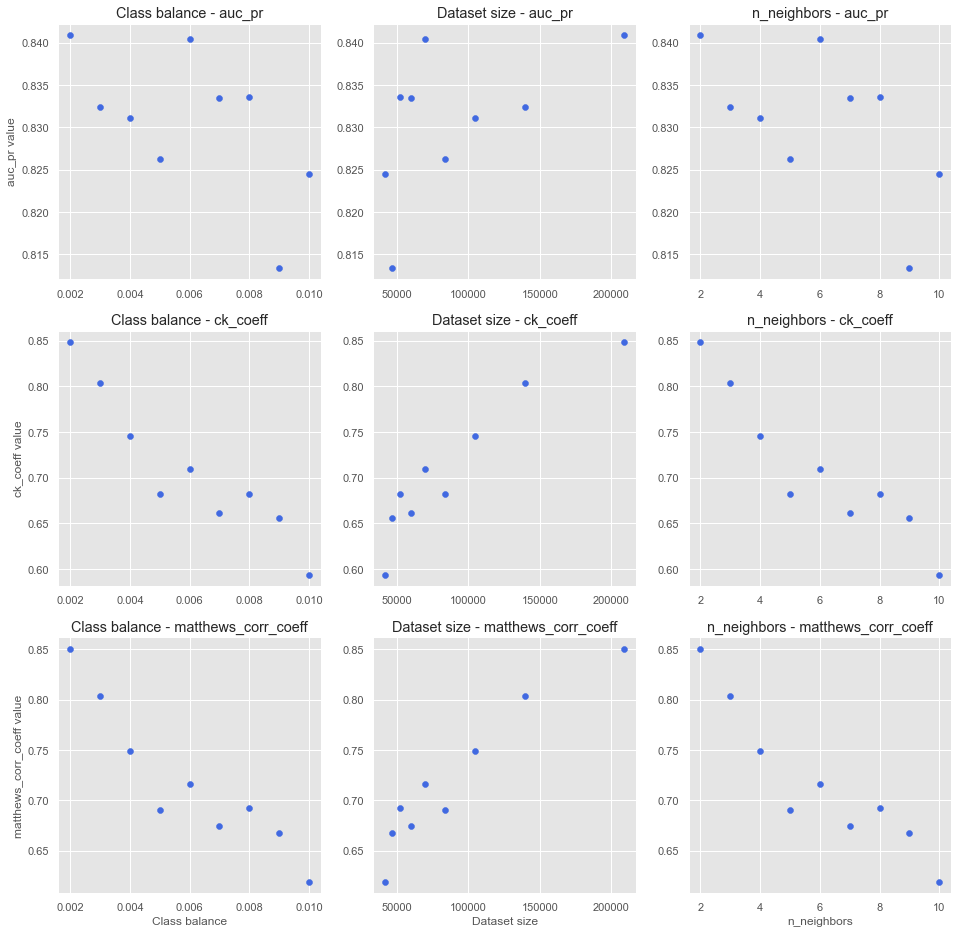

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 16))

parts = [0.001 * i for i in range(2, 11)]
ns = [i for i in range(2, 11)]


for i, metric in enumerate(tqdm([auc_pr, ck_coeff, matthews_corr_coeff], 'metric')):
    metric_results = []
    sizes = []
    balances = []
    for part, n_neib in zip(parts, ns):
        nm = NearMiss(sampling_strategy=part, n_neighbors=n_neib, n_jobs=-1)
        X_resampled, y_resampled = nm.fit_resample(X_train, y_train)
        counter = list(Counter(y_resampled).items())       
        
        sizes.append(X_resampled.shape[0])
        balances.append(counter[1][1] / counter[0][1])
        
        cb = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_resampled, y_resampled, verbose=False)
        y_proba_test = cb.predict_proba(X_test)[:, 1]
        metric_results.append(metric(y_test, y_proba_test))
        
    axes[i][0].scatter(balances, metric_results, label=metric.__name__, color='royalblue')
    axes[i][1].scatter(sizes, metric_results, label=metric.__name__, color='royalblue')
    axes[i][2].scatter(ns, metric_results, label=metric.__name__, color='royalblue')
    
    axes[i][0].set(title='Class balance - ' + metric.__name__)
    axes[i][1].set(title='Dataset size - ' + metric.__name__)
    axes[i][2].set(title='n_neighbors - ' + metric.__name__)

    
axes[-1][0].set_xlabel('Class balance')
axes[-1][1].set_xlabel('Dataset size')
axes[-1][2].set_xlabel('n_neighbors')
axes[0][0].set_ylabel('auc_pr value')
axes[1][0].set_ylabel('ck_coeff value')
axes[2][0].set_ylabel('matthews_corr_coeff value')

plt.show()

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.

Алгоритм CondensedNearestNeighbour использует правило одного ближайшего соседа, чтобы решить, стоит ли удалять объект или нет. 

Суть правила: имея выборку из $n$ верно классифицированных объектов, присваеваем новому объекту тот же класс, что и у ближайшего объекта их этих n. Здесь теория сводится к тому, что обсуждалось на лекции -- к оптимальности kNN. Было выявлено, что при соответствующих предположениях вероятность ошибки 1-NN не выше двух вероятностей ошибки идеального байесовского классификатора. Здесь как бы это и используется.

Алгоритм приведен в документации и в соответствующей [статье, стр. 515-516](http://dx.doi.org/10.1109/TIT.1968.1054155), поэтому не стану его описывать. Общая идея понятна.

In [60]:
from imblearn.under_sampling import CondensedNearestNeighbour
from time import time

cnn_kwargs = {
    'sampling_strategy': 'majority',
    'random_state': 10,
    'n_neighbors': 5,
    'n_jobs': -1
}

start = time()
X_cnn, y_cnn = CondensedNearestNeighbour(**cnn_kwargs).fit_resample(X_train, y_train)
catboost = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_cnn, y_cnn, verbose=False)
print('{:.4f} seconds'.format(time() - start))

y_proba_train = catboost.predict_proba(X_train)[:, 1]
y_proba_valid = catboost.predict_proba(X_valid)[:, 1]
y_proba_test = catboost.predict_proba(X_test)[:, 1]
print_results(y_proba_train, y_proba_valid, y_proba_test)

17045.2159 seconds
Train:
Cohen's Kappa: 0.0744            Matthew's Corr: 0.1963

Valid:
Cohen's Kappa: 0.0160            Matthew's Corr: 0.0783

Test:
Cohen's Kappa: 0.0476            Matthew's Corr: 0.1499



Что ж, алгоритм работал крайне долго, при этом результаты ущербные. Вероятно, проблема в неправильно подобранных гиперпараметрах, но с таким временем работы кода я понятия не имею, как можно их адекватно искать. Делаю вывод, что алгоритм не способен нормально работать с большими выборками.

In [63]:
print(sorted(Counter(y_cnn).items()))

[(0, 1389), (1, 417)]


Попробуем другой алгоритм. OneSidedSelection совмещает в себе идею с правилом одного ближайшего соседа и так называемые Tomek’s links для удаление шумовых объектов. В CondensedNearestNeighbour 1-NN правило применяется к объектам из множества S (что за множество указано [здесь](https://imbalanced-learn.org/stable/under_sampling.html#condensed-nearest-neighbors)). В OSS правило применяется ко всем объектам.

Ссылки Томека (думаю, так можно это перевести) -- это пары объектов разных классов, которые находятся близко друг к другу. Такие пары считаются easily misclassified, и было бы хорошо удалить какой-нибудь объект из пары. Идейно алгоритм хорошо показывает следующая визуализация:

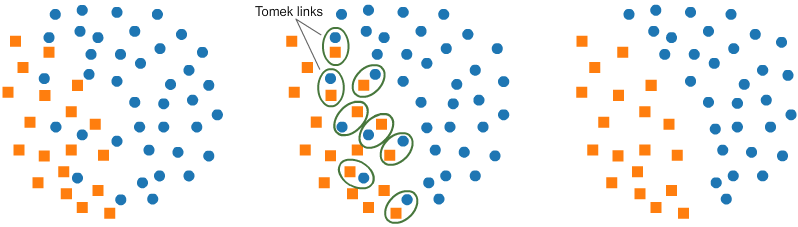

Там образом, алгоритм удаляет лишние объекты там, где нужно, что позволяет (говоря в терминах SMV) лучше построить разделяющую гиперплоскость.

In [67]:
from imblearn.under_sampling import OneSidedSelection

oss_kwargs = {
    'sampling_strategy': 'majority',
    'random_state': 10,
    'n_neighbors': 5
}

start = time()
X_oss, y_oss = OneSidedSelection(**oss_kwargs).fit_resample(X_train, y_train)
catboost = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_oss, y_oss, verbose=False)
print('{:.4f} seconds'.format(time() - start))

y_proba_train = catboost.predict_proba(X_train)[:, 1]
y_proba_valid = catboost.predict_proba(X_valid)[:, 1]
y_proba_test = catboost.predict_proba(X_test)[:, 1]
print_results(y_proba_train, y_proba_valid, y_proba_test)

891.8713 seconds
Train:
Cohen's Kappa: 0.8361            Matthew's Corr: 0.8364

Valid:
Cohen's Kappa: 0.7109            Matthew's Corr: 0.7111

Test:
Cohen's Kappa: 0.8365            Matthew's Corr: 0.8393



Вот тут уже адекватные результаты. Я рад.

**Бонус (2 балла)**. Сможете ли вы с помощью комбинации любых методов оверсэмплинга, андерсэмплинга и классификации набрать 0.8 на всех трех метриках?

In [58]:
nm = NearMiss(sampling_strategy=0.002, n_neighbors=5, n_jobs=-1)
X_resampled, y_resampled = nm.fit_resample(X_train, y_train)

catboost = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_resampled, y_resampled, verbose=False)
y_proba_test = catboost.predict_proba(X_test)[:, 1]

for metric in [auc_pr, ck_coeff, matthews_corr_coeff]:
    print(metric.__name__, ': {:.4f}'.format(metric(y_test, y_proba_test)), sep='')

auc_pr: 0.8397
ck_coeff: 0.8397
matthews_corr_coeff: 0.8412


Или так:

In [59]:
rus = RandomUnderSampler(sampling_strategy=0.002, random_state=10)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

catboost = CatBoostClassifier(**kwargs, task_type='GPU', devices='0:1').fit(X_resampled, y_resampled, verbose=False)

y_proba_test = catboost.predict_proba(X_test)[:, 1]

for metric in [auc_pr, ck_coeff, matthews_corr_coeff]:
    print(metric.__name__, ': {:.4f}'.format(metric(y_test, y_proba_test)), sep='')

auc_pr: 0.8522
ck_coeff: 0.8539
matthews_corr_coeff: 0.8586


# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [ ]:
def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    assert n != 0
    return np.log(n)


class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.
    
    Attributes:
        X: np.array - data available to current node
        size: int - length of available data
        
        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.
        
        Params:
            X: np.array - data available to current node
            depth: int - depth of node
            
            left: Node - left child
            right: Node - right child
            
            kind: str - either "internal" or "external", indicates the type of current node
            
            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane
            
        """
        self.size = len(X)
        
        self.depth = depth
        
        self.left = left
        self.right = right
        
        self.kind = kind
    
        self.w = w
        self.b = b
    
    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"

In [ ]:
def calc_height(X, depth, node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node
        
        depth: int - path length up to current node
        
        node: Node - current tree node
        
    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """
    scores = np.zeros(X.shape[0])

    #your code here

    
class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth
        
        max_depth: int - maximum tree depth
        
        root: Node - root node 

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes
        
    """
    def __init__(self, X, max_depth):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.max_depth = max_depth
        
        self.internal_count = 0
        self.external_count = 0

        self.root = self.grow(X, 0)
        
    def __repr__(self):
        """
        For convenience only.
        """
        
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"

        
    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample
            
            depth: int - current tree depth
            
        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        #your code here
        
        return Node(X, depth, left, right, kind, w, b)


    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated
            
        Returns:
            scores: np.array - estimated anomaly scores
        """
        #your code here

        return scores


class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees
        
        max_depth: int - maximum depth of each tree
        
        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
        
        trees: list - container for trained trees 
        
        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding
        
    """


    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.is_fit = False


    def __repr__(self):
        """For convenience only."""
        
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"
        
    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        #your code here
        return self
    

    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        #your code here

        return scores


    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        #your code here

        return labels

**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [ ]:
#your code here

Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

In [ ]:
#your code here

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [ ]:
#your code here

У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [ ]:
#your code here